# Personalized Programming Tutor - Week 2 Project 2

## Project Objective

Agente con inteligencia artificial multimodal para una aerolínea.

### desafío para este proyecto
- **Reservas** Añade otra herramienta para hacer una reserva
- **Traductor** Añade un agente que traduzca todas las respuestas a otro idioma
- **Audio** Añade otro agente que pueda escuchar audio y convertirlo a texto.


### Features:

- **Flexible**: Switch between Ollama (local, free) and OpenAI (cloud)
- **Interactive**: Streaming mode with typewriter effect
- **Educational**: Designed specifically for learning

---

**Instructions**: Execute the cells in order and modify the `question` variable to ask new questions.

---
**Models (ALL FREE!)**
- **Text** gemini-2.0-flash-exp (Google Gemini - FREE, 15 RPM)
- **Image** Pollinations AI (FREE - no API key needed)
- **Audio a Texto** Whisper large-v3 (ASR)
- **Texto a voz** gTTS (Google TTS - FREE)

In [19]:
# Import required libraries

import base64
import os
import json
import requests
import gradio as gr
from openai import OpenAI
from io import BytesIO
from pathlib import Path
from dotenv import load_dotenv
from huggingface_hub import InferenceClient
from IPython.display import Audio

In [21]:
# Load environment variables from .env file
load_dotenv(override=True)

# API keys from environment
ollama_base_url = os.getenv('OLLAMA_BASE_URL')
OLLAMA_API_KEY = os.getenv('OLLAMA_API_KEY')
HUGGINGFACE_API_KEY = os.getenv('HUGGINGFACE_API_KEY')

# Initialize Models
OLLAMA_CHAT_MODEL = "deepseek-v3.1:671b-cloud"
HUGGINGFACE_MODEL = "Soul-AILab/SoulX-Podcast-1.7B"

# Initialize clients
ollama_client = OpenAI(base_url=f"{ollama_base_url}/v1", api_key=OLLAMA_API_KEY)
huggingface_client = InferenceClient(api_key=HUGGINGFACE_API_KEY)

# Verify API keys
print(f"Ollama Client initialized ..." if ollama_client else "Ollama Client not initialized")
print(f"Huggingface Client initialized ..." if huggingface_client else "Huggingface Client not initialized")


Ollama Client initialized ...
Huggingface Client initialized ...


In [10]:
prompt = "New York City"

# llamada estilo 'Ollama Cloud' pero a FLUX
client_image = huggingface_client.text_to_image(
    prompt=prompt,
    model=HUGGINGFACE_MODEL
)

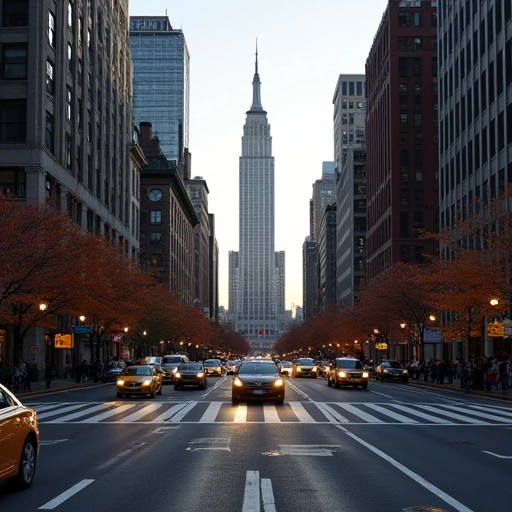

In [11]:
# ver en notebook y guardar
display(client_image)

In [20]:
# Cliente usando el nuevo router (Inference Providers)
client = InferenceClient(
    provider="hf-inference",  # usa router.huggingface.co por debajo
    api_key=HUGGINGFACE_API_KEY,
)

In [22]:
def texto_a_audio(
    texto: str,
    filename: str = "salida.flac",
    model: str = "Soul-AILab/SoulX-Podcast-1.7B",  # buen modelo TTS para voz tipo podcast
) -> str:
    """
    Convierte texto en audio y guarda el resultado en filename.
    Devuelve la ruta del archivo.
    """
    audio_bytes = client.text_to_speech(
        texto,
        model=HUGGINGFACE_MODEL,
        # extra_body={"voice": "af_nicole"}  # ejemplo de parámetro de voz para otros modelos como Kokoro
    )
    Path(filename).write_bytes(audio_bytes)
    return filename


if __name__ == "__main__":
    texto = "Hola Oscar, este es un mensaje de prueba para tu podcast sobre Big Data."
    fname = texto_a_audio(texto, "podcast_intro.flac")
    print("Archivo guardado en:", fname)

HfHubHTTPError: Client error '404 Not Found' for url 'https://router.huggingface.co/hf-inference/models/Soul-AILab/SoulX-Podcast-1.7B' (Request ID: Root=1-6916b999-03dce08933264d0816492ab7;5b5c1741-3aa6-4180-b3fb-1a0db878bd86)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404

In [51]:
# Ejemplo de uso
texto = "Hola Oscar, este es un mensaje enviado por la API de Hugging Face."
fname, audio_widget = clientTextAudio(texto)

display(audio_widget)
print("Archivo guardado en:", fname)

HTTPError: 410 Client Error: Gone for url: https://api-inference.huggingface.co/models/microsoft/speecht5_tts

### Nueva etapa: Audio/TTS (Text-to-Speech)

Ahora vamos a agregar generación de voz para que el asistente pueda "hablar" las respuestas.

In [ ]:
# Audio TTS usando gTTS (100% GRATIS)
from gtts import gTTS
from io import BytesIO

print("🎵 TTS configurado con gTTS (Google Text-to-Speech - FREE)")

In [ ]:
# Test gTTS (Google TTS - FREE)
audio_test = talker_local_gtts("Hello! Welcome to New York City.")
if audio_test:
    print(f"✅ Audio generated: {len(audio_test)} bytes")
    with open("test_audio_gtts.mp3", "wb") as f:
        f.write(audio_test)
    print("💾 Saved to test_audio_gtts.mp3")

In [ ]:
# Install: pip install pyttsx3
# For Google TTS: pip install gtts

def talker_local_pyttsx3(message):
    """
    Generate speech locally using pyttsx3 (FREE - offline)
    Quality: Basic but functional
    """
    try:
        import pyttsx3
        engine = pyttsx3.init()
        
        # Save to file
        output_file = "audio_local.mp3"
        engine.save_to_file(message, output_file)
        engine.runAndWait()
        
        # Read file content
        with open(output_file, "rb") as f:
            return f.read()
    except ImportError:
        print(" Install: pip install pyttsx3")
        return None

In [ ]:
talker_local_pyttsx3("Hello! Welcome to New York City.")

In [ ]:
def talker_local_gtts(message):
    """
    Generate speech using Google TTS (FREE - requires internet)
    Quality: Better than pyttsx3, similar to basic cloud TTS
    """
    try:
        from gtts import gTTS
        from io import BytesIO
        
        # Generate speech
        tts = gTTS(text=message, lang='es')  # Change 'es' to 'en' for English
        
        # Save to BytesIO
        audio_fp = BytesIO()
        tts.write_to_fp(audio_fp)
        audio_fp.seek(0)
        
        return audio_fp.read()
    except ImportError:
        print(" Install: pip install gtts")
        return None

In [ ]:
# Test gTTS - Generate and save audio
audio_gtts = talker_local_gtts("Hello! Welcome to New York City.")

if audio_gtts:
    print(f" Audio generated: {len(audio_gtts)} bytes")
    
    # Save to file to listen
    with open("test_audio_gtts.mp3", "wb") as f:
        f.write(audio_gtts)
    print(" Saved to test_audio_gtts.mp3")
    print("You can now download and play this file")
else:
    print(" Failed to generate audio")

In [ ]:
# Install Coqui TTS: pip install TTS

# Available voices/models for Coqui TTS
COQUI_VOICES = {
    # === LIGHTWEIGHT MODELS (Recommended for notebooks) ===
    "tacotron2_en": "tts_models/en/ljspeech/tacotron2-DDC",      # ~100MB - Female English (FASTEST)
    "tacotron2_es": "tts_models/es/mai/tacotron2-DDC",           # ~100MB - Female Spanish
    "glow_tts_en": "tts_models/en/ljspeech/glow-tts",            # ~120MB - Female English (good quality)
    
    # === MEDIUM MODELS ===
    "vits_en": "tts_models/en/ljspeech/vits",                    # ~200MB - Better quality
    "vits_es": "tts_models/es/css10/vits",                       # ~200MB - Spanish better quality
    
    # === HEAVY MODELS (NOT RECOMMENDED for notebooks) ===
    "jenny": "tts_models/en/jenny/jenny",                        # 🔴 1.6GB - Very high quality (TOO HEAVY)
    "vctk": "tts_models/en/vctk/vits",                           # 🔴 ~800MB - Multiple speakers
}

# Print available voices with size info
print("🎤 Available Coqui TTS Voices:")
print("\n✅ LIGHTWEIGHT (Recommended):")
print("  - tacotron2_en: ~100MB - Female English (fastest)")
print("  - tacotron2_es: ~100MB - Female Spanish")
print("  - glow_tts_en: ~120MB - Female English (good quality)")
print("\n⚠️ MEDIUM:")
print("  - vits_en: ~200MB - Better quality")
print("  - vits_es: ~200MB - Spanish better quality")
print("\n🔴 HEAVY (Avoid in notebooks):")
print("  - jenny: 1.6GB - Very high quality (TOO HEAVY)")
print("  - vctk: ~800MB - Multiple speakers")

In [ ]:
def talker_coqui(message, voice="tacotron2_es"):
    """
    Generate speech using Coqui TTS (FREE - high quality, multiple voices)
    
    Args:
        message: Text to convert to speech
        voice: Voice name from COQUI_VOICES (default: "jenny")
        
    Available voices:
        - jenny (Female, American English - RECOMMENDED)
        - ljspeech (Female, neutral English)
        - mai_es (Female, Spanish)
        - css10_es (Female, Spanish - better quality)
    """
    try:
        from TTS.api import TTS
        import tempfile
        import os
        
        # Get model path from voice name
        model_path = COQUI_VOICES.get(voice, COQUI_VOICES["tacotron2_es"])
        
        print(f"🔊 Loading Coqui TTS model: {voice}")
        print(f"   Model: {model_path}")
        print(f"   Note: First run will download the model (~100-500MB)")
        
        # Initialize TTS
        tts = TTS(model_path)
        
        # Create temporary file
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp_file:
            tmp_path = tmp_file.name
        
        # Generate speech
        tts.tts_to_file(text=message, file_path=tmp_path)
        
        # Read audio data
        with open(tmp_path, "rb") as f:
            audio_data = f.read()
        
        # Clean up temp file
        os.unlink(tmp_path)
        
        print(f" Audio generated: {len(audio_data)} bytes")
        return audio_data
        
    except ImportError:
        print(" Coqui TTS not installed")
        print("   Install: pip install TTS")
        return None
    except Exception as e:
        print(f" Error generating audio: {e}")
        return None

In [ ]:
# Test Coqui TTS with LIGHTWEIGHT model

# Test 1: Tacotron2 (English - LIGHTWEIGHT ~100MB)
print("=" * 50)
print("Testing voice: tacotron2_en (English - LIGHTWEIGHT)")
print("=" * 50)
audio_coqui = talker_coqui("Hello! Welcome to New York City.", voice="tacotron2_en")

if audio_coqui:
    with open("test_audio_coqui_tacotron2.wav", "wb") as f:
        f.write(audio_coqui)
    print("💾 Saved to test_audio_coqui_tacotron2.wav")
    print()

# Test 2: Spanish lightweight (uncomment to test)
# print("=" * 50)
# print("Testing voice: tacotron2_es (Spanish - LIGHTWEIGHT)")
# print("=" * 50)
# audio_coqui_es = talker_coqui("Hola! Bienvenido a Nueva York.", voice="tacotron2_es")
# if audio_coqui_es:
#     with open("test_audio_coqui_spanish.wav", "wb") as f:
#         f.write(audio_coqui_es)
#     print("💾 Saved to test_audio_coqui_spanish.wav")

## Integrando Todo: Chat + Tools + Images + Audio

Ahora vamos a juntar todo en un asistente multimodal completo.

In [ ]:
# Configuration for the airline assistant
system_message = """
Eres un asistente útil para una aerolínea llamada FlightAI.
Da respuestas breves y corteses, de no más de una oración.
Se siempre preciso. Si no sabes la respuesta, dilo.
"""

# Choose which model to use for chat (ALL FREE OPTIONS)
# MODEL = OLLAMA_CHAT_MODEL  # "deepseek-v3.1:671b-cloud" - Ollama FREE
MODEL = GEMINI_CHAT_MODEL  # "gemini-2.0-flash-exp" - Google FREE (RECOMMENDED)

print(f"✅ Chat Model configured: {MODEL}")

In [ ]:
# Define ticket prices database (from day4)
ticket_prices = {
    "londres": "$799",
    "paris": "$899",
    "tokyo": "$1400",
    "berlin": "$499",
    "new york": "$650",
    "barcelona": "$550",
    "miami": "$450"
}

def get_ticket_price(destination_city):
    """Get the price of a ticket to a specific city"""
    print(f"🔧 Tool called for city: {destination_city}")
    price = ticket_prices.get(destination_city.lower(), "Unknown ticket price")
    return f"The price of a ticket to {destination_city} is {price}"

In [ ]:
# Define the tool for OpenAI function calling
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": price_function}]
print(f" Tools configured: {len(tools)} tool(s)")

## Let's bring this home:

1. A multi-modal AI assistant with image and audio generation
2. Tool callling with database lookup
3. A step towards an Agentic workflow


In [ ]:
# Audio TTS Configuration - Choose your preferred TTS engine

# Option 1: Google TTS Free (RECOMMENDED - FREE, good quality)
USE_TTS_FUNCTION = talker_local_gtts

# Option 2: Coqui TTS (FREE - offline, high quality but larger model)
# USE_TTS_FUNCTION = lambda msg: talker_coqui(msg, voice="tacotron2_en")

In [ ]:
def chat(history):
    """
    Main chat function that integrates:
    - Chat with Tools (Gemini or Ollama - both FREE)
    - Image generation (Google Imagen 4 - FREE)
    - Audio generation (gTTS - FREE)
    """
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    
    cities = []
    image = None
    
    # Choose client based on model
    if MODEL == GEMINI_CHAT_MODEL:
        # Use Google Gemini (FREE)
        # Convert messages to Gemini format
        gemini_messages = []
        for msg in messages:
            if msg["role"] == "system":
                continue  # Gemini doesn't use system messages the same way
            gemini_messages.append({
                "role": "user" if msg["role"] == "user" else "model",
                "parts": [{"text": msg["content"]}]
            })
        
        # Add system message as first user message
        if messages and messages[0]["role"] == "system":
            gemini_messages.insert(0, {
                "role": "user",
                "parts": [{"text": messages[0]["content"]}]
            })
        
        response = google_client.models.generate_content(
            model=MODEL,
            contents=gemini_messages
        )
        
        reply = response.text
        
        # Extract city from reply (simple heuristic)
        for city in ticket_prices.keys():
            if city.lower() in reply.lower():
                cities.append(city)
                break
    else:
        # Use Ollama client (works with OpenAI-compatible API)
        response = ollama_client.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools
        )
        
        # Handle tool calls (if any)
        while response.choices[0].finish_reason=="tool_calls":
            message = response.choices[0].message
            responses, cities = handle_tool_calls_and_return_cities(message)
            messages.append(message)
            messages.extend(responses)
            response = ollama_client.chat.completions.create(
                model=MODEL,
                messages=messages,
                tools=tools
            )
        
        reply = response.choices[0].message.content
    
    history += [{"role":"assistant", "content":reply}]

    # Generate audio from reply using configured TTS engine
    voice = USE_TTS_FUNCTION(reply)

    # Generate image if a city was mentioned
    if cities:
        image = artist(cities[0])
    
    return history, voice, image


In [ ]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses, cities

In [ ]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )


In [ ]:
# Launch the Gradio interface
# Important: Use server_name="0.0.0.0" for Docker/remote access

ui.launch(share=True)